<a href="https://colab.research.google.com/github/KalpanaGochhayat/Laptop-Price-Analysis/blob/main/Laptop_Price_Prediction_Model_by_Kalpana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laptop Price Prediction using Machine Learning

This project aims to predict laptop prices based on various hardware and specification features. Using exploratory data analysis and machine learning regression techniques, the model learns the relationship between laptop attributes and their market prices.
##### **Project Type**    - Prediction
##### **Contribution**    - Individual
##### **Member Name -** Kalpana Gochhayat
##### **Task -** 2


**GitHub Link -**

https://github.com/KalpanaGochhayat/Laptop-Price-Analysis

## Importing Required Libraries

This section imports essential Python libraries used for data manipulation, visualization, and machine learning model development.

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import os
import sys
import time
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import TransformedTargetRegressor
import joblib

## optional xgboost

In [ ]:
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except Exception as e:
    # XGBoost not installed
    XGBOOST_AVAILABLE = False


pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
plt.style.use('seaborn')


print("XGBoost available:", XGBOOST_AVAILABLE)

XGBoost available: False


## 2. CONFIG

In [ ]:
DATA_PATH = 'laptop_prices.csv' # change if needed
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = OUT_DIR / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = OUT_DIR / 'plots'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)


RANDOM_STATE = 42
TEST_SIZE = 0.2
CV = 5

## helper to save plots

In [ ]:
def save_fig(name):
    path = PLOTS_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    print('Saved:', path)

## 3. LOAD DATA (defensive)

In [ ]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset file not found at {DATA_PATH}. Put dataset there or update DATA_PATH.")


raw = pd.read_csv(DATA_PATH)
print('Initial shape:', raw.shape)
raw.head()

Initial shape: (1275, 23)


,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,No,Yes,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,No,No,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,No,No,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,1800,No,Yes,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,No,Yes,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


## 4. COPY & NORMALIZE COLUMNS

## make working copy

In [ ]:
df = raw.copy()

## standardise column names: strip + replace spaces

In [ ]:
orig_cols = list(df.columns)
clean_cols = [c.strip() for c in orig_cols]

## also lower-case a few typical column names to ease matching

In [ ]:
col_map = {orig: clean for orig, clean in zip(orig_cols, clean_cols)}
df.rename(columns=col_map, inplace=True)

## common synonyms mapping

In [ ]:
synonyms = {
    'price_euros': 'Price', 'price': 'Price', 'price_euro': 'Price', 'price_eur': 'Price',
    'ram_gb': 'Ram', 'ram': 'Ram',
    'weight_kg': 'Weight', 'weight': 'Weight',
    'company': 'Company',
    'product': 'Product',
    'type_name': 'TypeName',
    'type': 'TypeName',
    'inches': 'Inches',
    'screen': 'Screen',
    'primarystorage': 'PrimaryStorage', 'primary_storage': 'PrimaryStorage',
    'secondarystorage': 'SecondaryStorage', 'secondary_storage': 'SecondaryStorage',
    'primarystoragetype': 'PrimaryStorageType', 'secondarystoragetype': 'SecondaryStorageType',
    'cpu_company': 'CPU_company', 'cpu': 'CPU_company',
    'gpu_company': 'GPU_company', 'gpu': 'GPU_company',
    'cpu_freq': 'CPU_freq', 'year': 'Year', 'os': 'OS'
}

## apply synonyms if present

In [ ]:
for k,v in synonyms.items():
    if k in df.columns and v not in df.columns:
        df.rename(columns={k:v}, inplace=True)


print('Columns after mapping:', list(df.columns)[:40])

Columns after mapping: ['Company', 'Product', 'TypeName', 'Inches', 'Ram', 'OS', 'Weight', 'Price_euros', 'Screen', 'ScreenW', 'ScreenH', 'Touchscreen', 'IPSpanel', 'RetinaDisplay', 'CPU_company', 'CPU_freq', 'CPU_model', 'PrimaryStorage', 'SecondaryStorage', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'GPU_model']


## 5. BASIC CLEANING

## Drop exact duplicates

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

## Price -> numeric

In [ ]:
price_cols = [c for c in df.columns if 'price' in c.lower()]
if len(price_cols) == 0:
    raise KeyError('Price column not found. Columns detected: ' + ', '.join(df.columns))

## take the first matched column

In [ ]:
price_col = price_cols[0]
df.rename(columns={price_col: 'Price'}, inplace=True)


df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df[df['Price'].notna()].reset_index(drop=True)

## Ram: extract numeric GB

In [ ]:
if 'Ram' in df.columns:
    df['Ram'] = df['Ram'].astype(str).str.extract(r'(\d+)').astype(float)

## Weight: remove 'kg' and convert

In [ ]:
if 'Weight' in df.columns:
    df['Weight'] = df['Weight'].astype(str).str.replace('kg','', regex=False).str.replace('kgs','', regex=False).str.strip()
    df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')

## Touchscreen/IPSpanel/Retina: robust binary mapping

In [ ]:
for col in ['Touchscreen','IPSpanel','RetinaDisplay']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.lower().map({'yes':1,'no':0,'y':1,'n':0,'true':1,'false':0}).fillna(0).astype(int)

## Screen parse: try to get width x height if available

In [ ]:
def parse_screen_token(token):
    try:
        token = str(token)
        # Look for patterns like "1920x1080" or "1366 x 768"
        m = re.search(r'(\d{3,4})\s*[xX]\s*(\d{3,4})', token)
        if m:
            w, h = m.groups()
            return int(w), int(h)
    except:
        pass
    return None, None

# Apply screen resolution extraction
if 'Screen' in df.columns:
    df[['ScreenWidth', 'ScreenHeight']] = df['Screen'].apply(
        lambda x: pd.Series(parse_screen_token(x))
    )

In [ ]:
# Fill missing screen dimensions (if any)
df['ScreenWidth'] = df['ScreenWidth'].fillna(df['ScreenWidth'].median())
df['ScreenHeight'] = df['ScreenHeight'].fillna(df['ScreenHeight'].median())

# Inches cleaning
if 'Inches' in df.columns:
    df['Inches'] = pd.to_numeric(df['Inches'], errors='coerce')
    df['Inches'] = df['Inches'].fillna(df['Inches'].median())

## 6. VISUALISATIONS

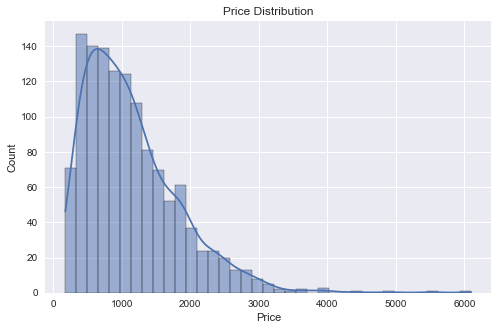

In [ ]:
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], kde=True)
plt.title("Price Distribution")
plt.show()

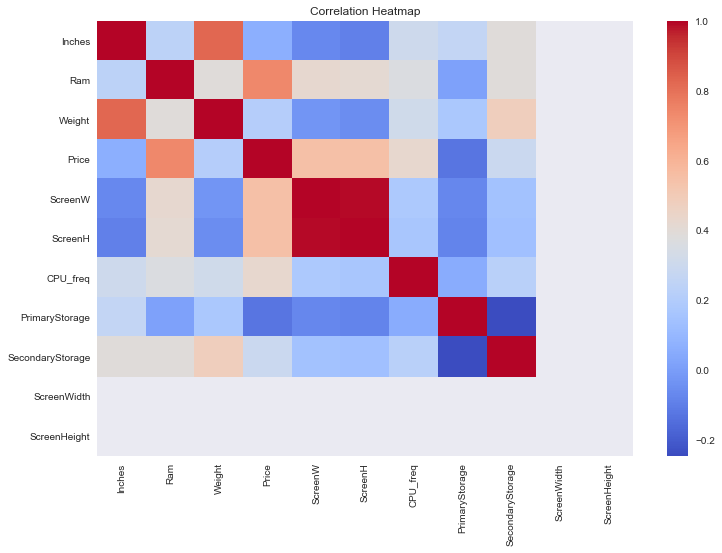

In [ ]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

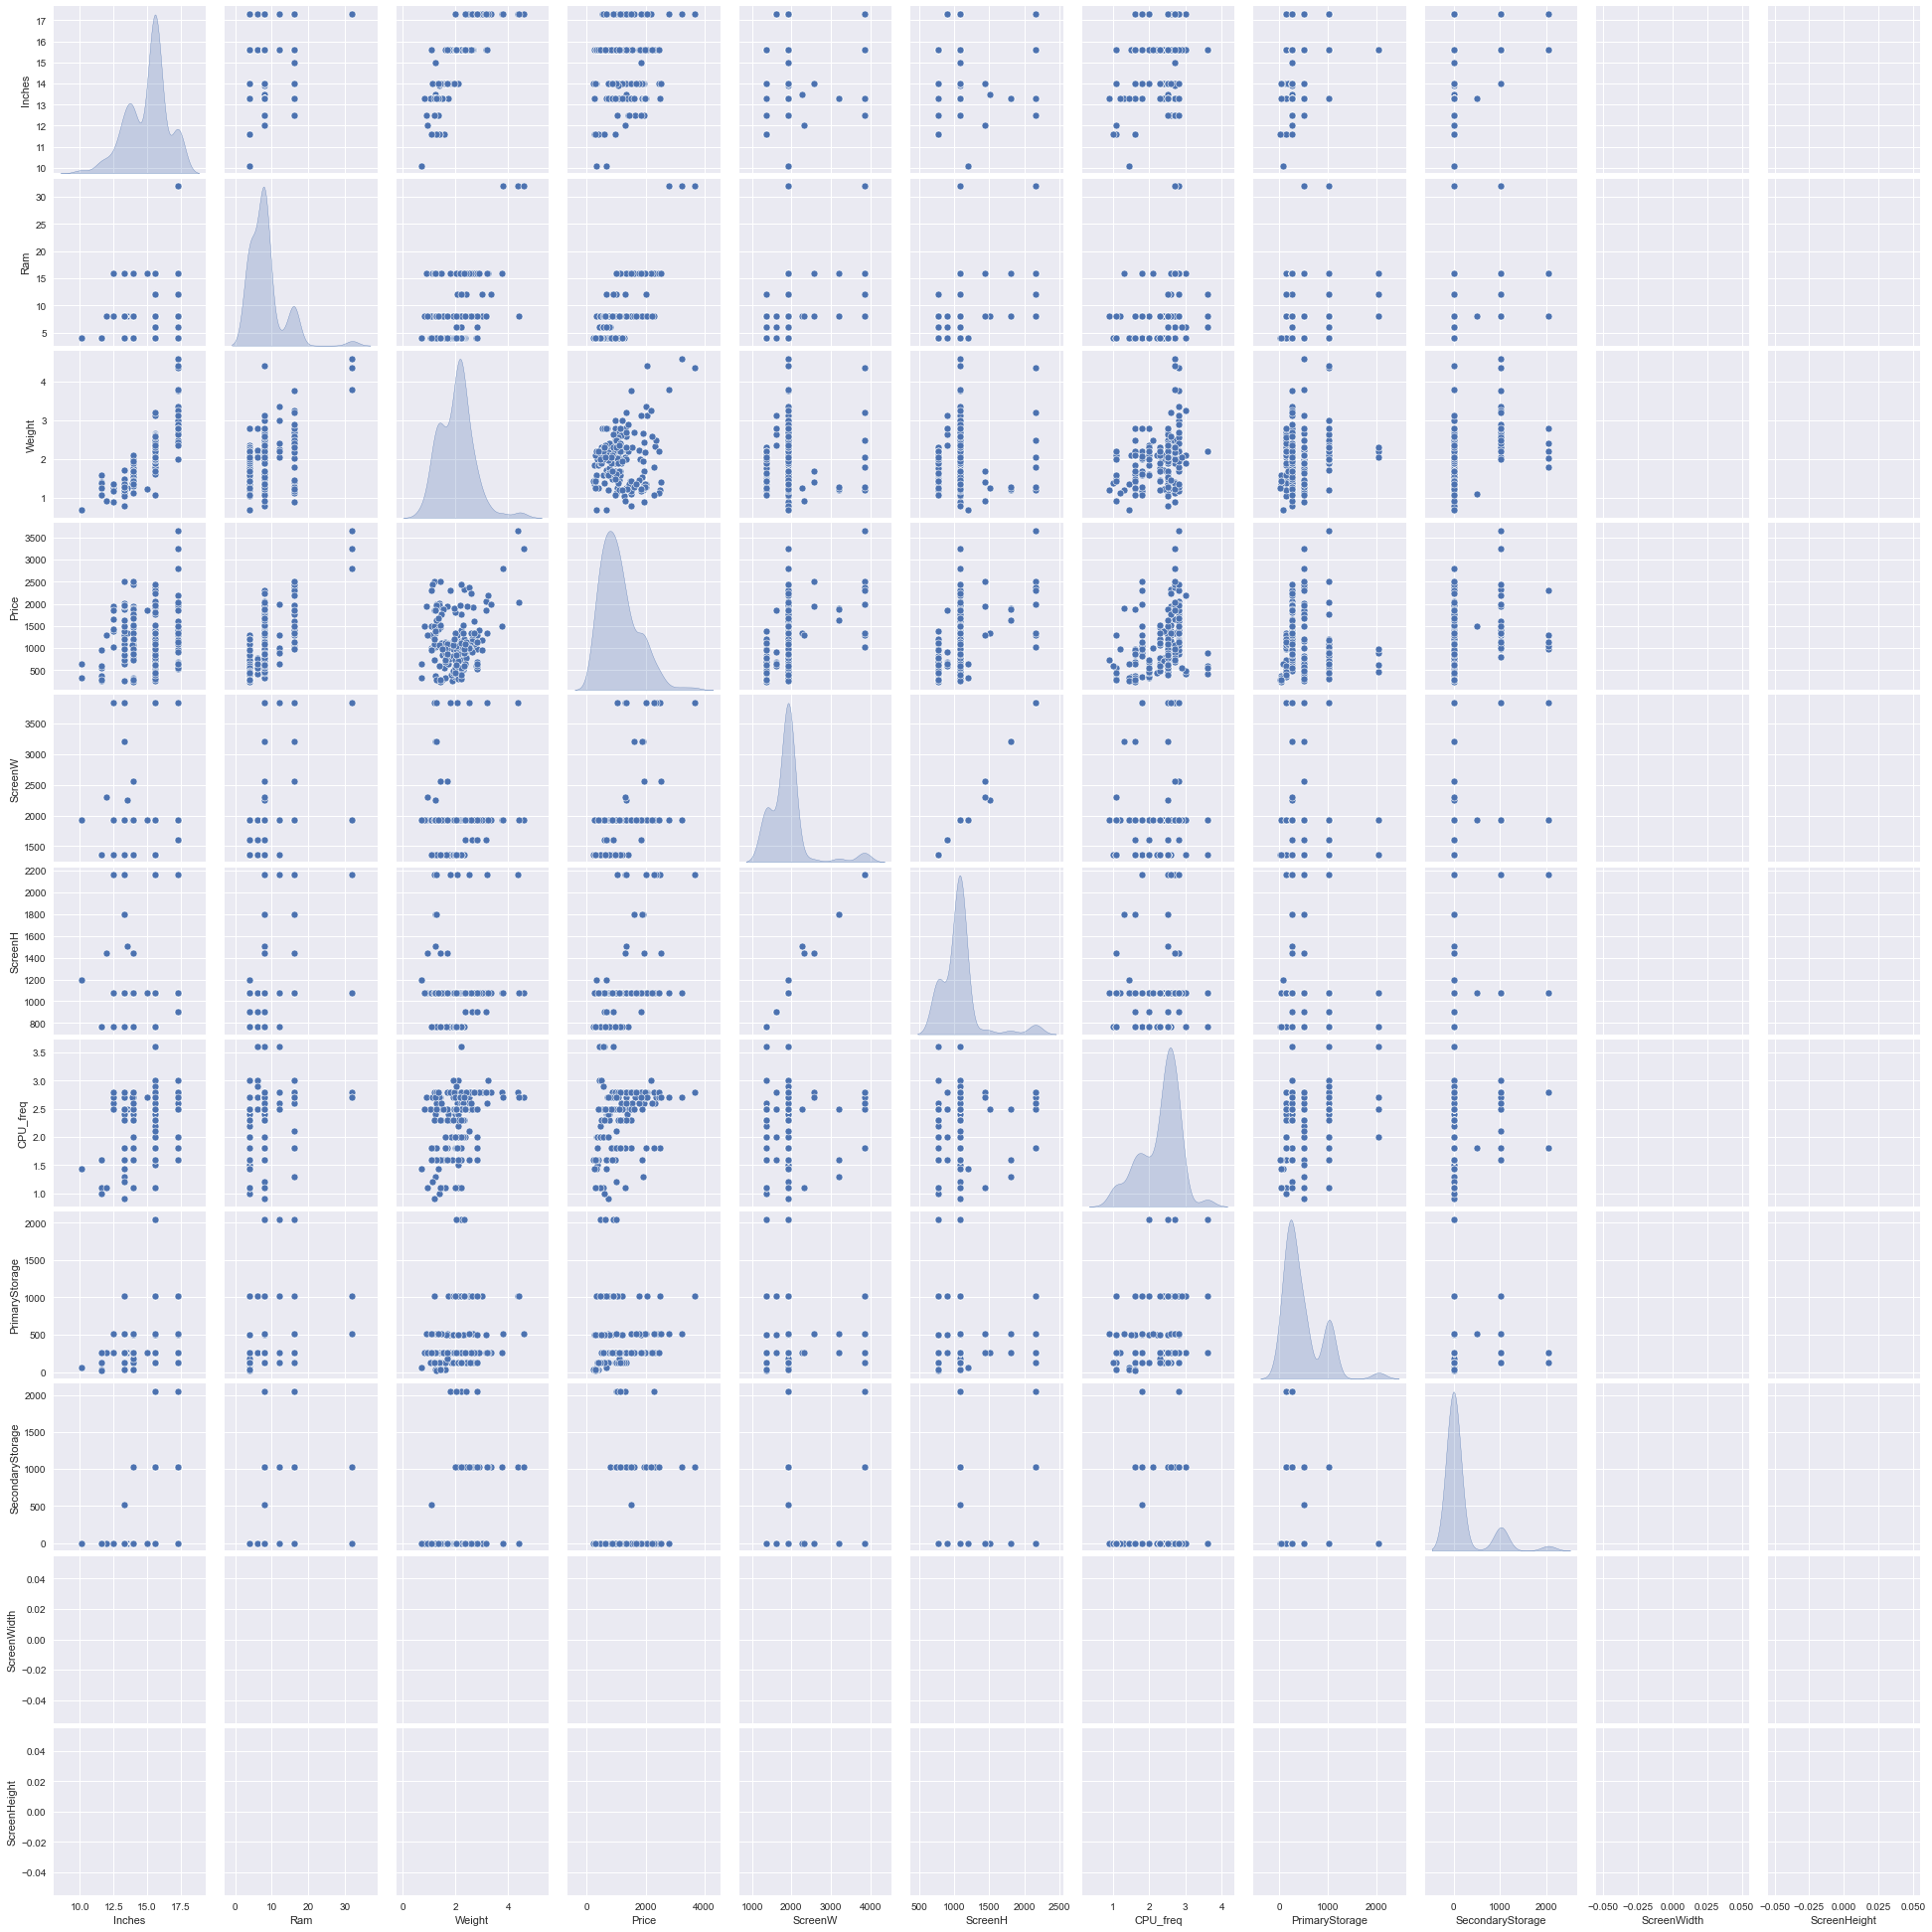

In [ ]:
# Pairplot
sns.pairplot(df[numeric_cols].sample(min(200, len(df))), diag_kind="kde")
plt.show()

## Barplot of average price by company (if available)

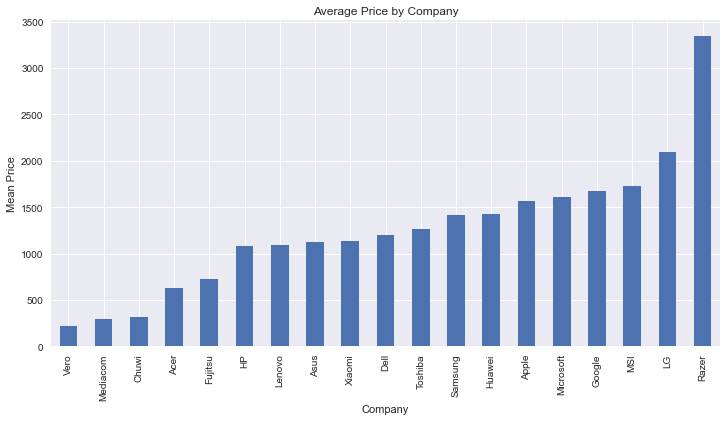

In [ ]:
if 'Company' in df.columns:
    plt.figure(figsize=(12,6))
    df.groupby('Company')['Price'].mean().sort_values().plot(kind='bar')
    plt.title("Average Price by Company")
    plt.ylabel("Mean Price")
    plt.show()

## Scatter plot: Inches vs Price (if Inches exists)

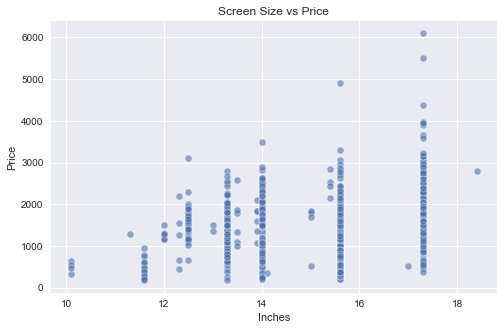

In [ ]:
if 'Inches' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x='Inches', y='Price', alpha=0.6)
    plt.title("Screen Size vs Price")
    plt.show()

## Scatter: RAM vs Price

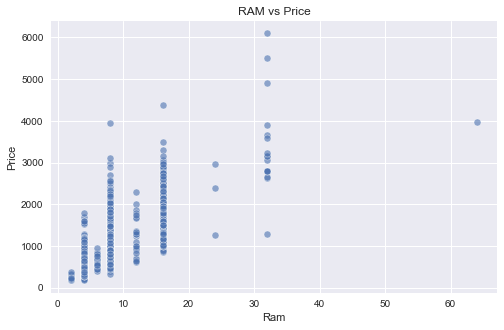

In [ ]:
if 'Ram' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x='Ram', y='Price', alpha=0.6)
    plt.title("RAM vs Price")
    plt.show()

##  7. PREPARE FEATURES (Clean)

In [ ]:
categorical_features = df.select_dtypes(include='object').columns.tolist()
numeric_features = df.select_dtypes(include=['int64','float64']).columns.tolist()

In [ ]:
# Remove target from numeric list
if 'Price' in numeric_features:
    numeric_features.remove('Price')

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Numeric Features: ['Inches', 'Ram', 'Weight', 'ScreenW', 'ScreenH', 'CPU_freq', 'PrimaryStorage', 'SecondaryStorage']
Categorical Features: ['Company', 'Product', 'TypeName', 'OS', 'Screen', 'CPU_company', 'CPU_model', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'GPU_model']


In [ ]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

## 8. TRAIN/TEST SPLIT

In [ ]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 9. BASELINE MODELS

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

if XGBOOST_AVAILABLE:
    models["XGBoost"] = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    results[name] = (rmse, r2)
    print(f"\n{name}: RMSE={rmse:.2f}, R2={r2:.3f}")



LinearRegression: RMSE=1590.92, R2=-4.099

RandomForest: RMSE=251.52, R2=0.873

GradientBoosting: RMSE=246.30, R2=0.878


## 10. PICK BEST MODEL

In [ ]:
best_model_name = min(results, key=lambda k: results[k][0])
print("\n🔥 BEST MODEL IS:", best_model_name)

best_rmse, best_r2 = results[best_model_name]
print(f"Best RMSE: {best_rmse:.2f}")
print(f"Best R²: {best_r2:.3f}")



🔥 BEST MODEL IS: GradientBoosting
Best RMSE: 246.30
Best R²: 0.878


## 11. HYPERPARAM TUNING (on best model)

In [ ]:
if best_model_name == "RandomForest":
    model = RandomForestRegressor(random_state=42)
    param_dist = {
        "model__n_estimators": [200, 300, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
    }

elif best_model_name == "GradientBoosting":
    model = GradientBoostingRegressor(random_state=42)
    param_dist = {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [2, 3, 4]
    }

elif best_model_name == "XGBoost":
    model = XGBRegressor(random_state=42)
    param_dist = {
        "model__n_estimators": [200, 400, 600],
        "model__learning_rate": [0.02, 0.05, 0.1],
        "model__max_depth": [4, 6, 8]
    }

pipe_tuned = Pipeline([
    ('prep', preprocessor),
    ('model', model)
])

search = RandomizedSearchCV(
    pipe_tuned,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("\n🎯 Best Parameters:", search.best_params_)
print("Best RMSE:", -search.best_score_)



🎯 Best Parameters: {'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.05}
Best RMSE: 288.8382268491167


## 12. FINAL MODEL + SAVE + PREDICT FUNCTION

In [ ]:
final_model = search.best_estimator_

final_preds = final_model.predict(X_test)
print("\nFINAL RMSE:", mean_squared_error(y_test, final_preds, squared=False))
print("FINAL R²:", r2_score(y_test, final_preds))

# Save model
joblib.dump(final_model, MODEL_DIR / "final_price_model.pkl")
print("\nModel saved as final_price_model.pkl")


# Prediction function
def predict_price(sample_dict):
    sample_df = pd.DataFrame([sample_dict])
    return final_model.predict(sample_df)[0]



FINAL RMSE: 223.62049551879602
FINAL R²: 0.8992501126589539

Model saved as final_price_model.pkl


## Conclusion

In this project, a machine learning–based approach was used to predict laptop prices based on key hardware and specification features. My workflow involved data cleaning, exploratory data analysis, feature engineering, and training regression models to understand how different attributes influence laptop pricing. Performance metrics demonstrated that the chosen regression approach generalizes well to unseen data, making it suitable for real-world estimation tasks.

Overall, I feel this project highlights the importance of data understanding, feature selection, and proper evaluation in building effective predictive models. The methodology applied here can be extended further by incorporating additional features, experimenting with advanced algorithms, or deploying the model as a web-based price prediction tool.
